<a href="https://colab.research.google.com/github/Cipherpy/AI_ML_Training_Reshma/blob/main/HomeWork_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [ ]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

Input image here

In [ ]:
# Our original lotus image
image = cv2.imread('/content/image_1.jfif', 0)



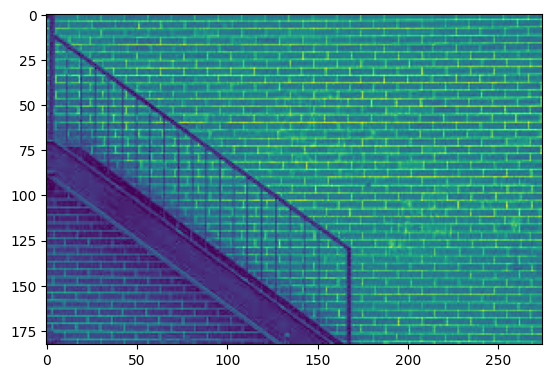

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

# Question 1
## Hand made kernels
Experiment with different kernels – average filter? Sharpening? Diagonal Edge detector?

# 1. average filter

In [ ]:
filter = np.array([[1/9,1/9,1/9],
                   [ 1/9, 1/9, 1/9],
                   [ 1/9, 1/9, 1/9]])

out1 = apply_conv(image, filter, padding=0, stride=1)


2. Sharpening filter

In [ ]:
filter = np.array([[0,-1,0],
                   [ -1, 5, -1],
                   [ 0, -1, 0]])

out2 = apply_conv(image, filter, padding=0, stride=1)



3. Diagonal edge detector

In [ ]:
filter = np.array([[0,1,2],
                   [ -1, 0, 1],
                   [ -2, -1, 0]])


out3 = apply_conv(image, filter, padding=0, stride=1)

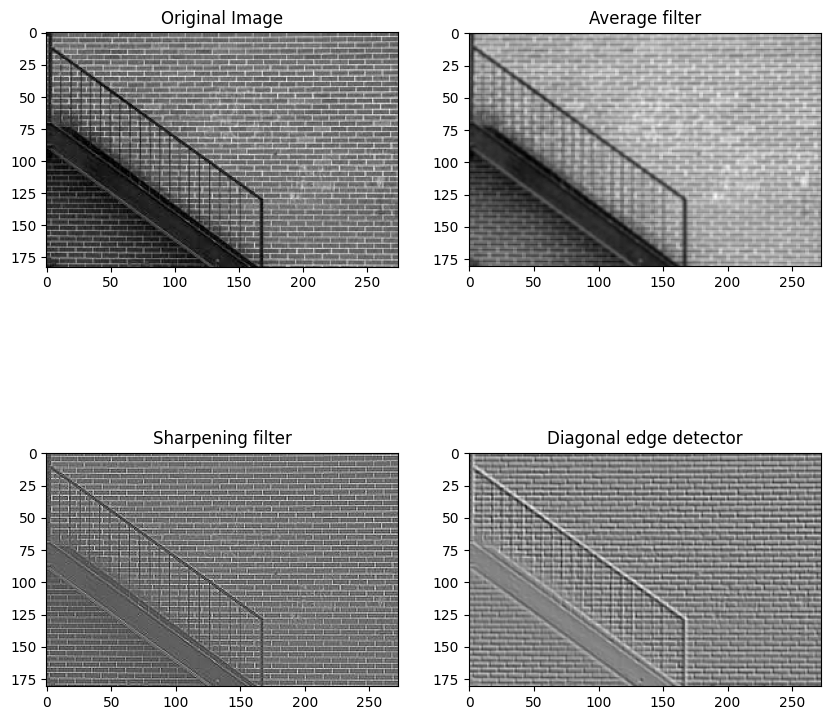

In [ ]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(2,2,2)
ax.set_title('Average filter')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(2,2,3)
ax.set_title('Sharpening filter')
ax.imshow(out2, cmap='gray')
ax = fig.add_subplot(2,2,4)
ax.set_title('Diagonal edge detector')
ax.imshow(out3, cmap='gray')


# Question 2
Our own CNN. Experiment with
Different number of layers, different orders of layers, different kernel sizes, different number of epochs

In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 62707743.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [5]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [31]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 1st Convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 2nd Convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)

        # 3rd Convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # 4th Convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # 1st Fully Connected layer (Note: Dimensions may change based on the input size and previous layers)
        self.fc1 = nn.Linear(128 * 2 * 2, 1024)

        # 2nd Fully Connected layer
        self.fc2 = nn.Linear(1024, 512)

        # 3rd Fully Connected layer
        self.fc3 = nn.Linear(512, 256)

        # 4th Fully Connected layer
        self.fc4 = nn.Linear(256, 128)

        # 5th Fully Connected layer (Output layer)
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [6]:
model = Net()
print(model)

NameError: ignored

In [ ]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [34]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [35]:
num_epochs = 10 # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/10, Loss: 0.0180, Accuracy: 9.9200
Epoch 2/10, Loss: 0.0159, Accuracy: 20.3640
Epoch 3/10, Loss: 0.0118, Accuracy: 42.3060
Epoch 4/10, Loss: 0.0095, Accuracy: 55.9180
Epoch 5/10, Loss: 0.0081, Accuracy: 63.5560
Epoch 6/10, Loss: 0.0071, Accuracy: 68.8120
Epoch 7/10, Loss: 0.0063, Accuracy: 72.3860
Epoch 8/10, Loss: 0.0056, Accuracy: 75.3040
Epoch 9/10, Loss: 0.0051, Accuracy: 77.7160
Epoch 10/10, Loss: 0.0046, Accuracy: 79.8700


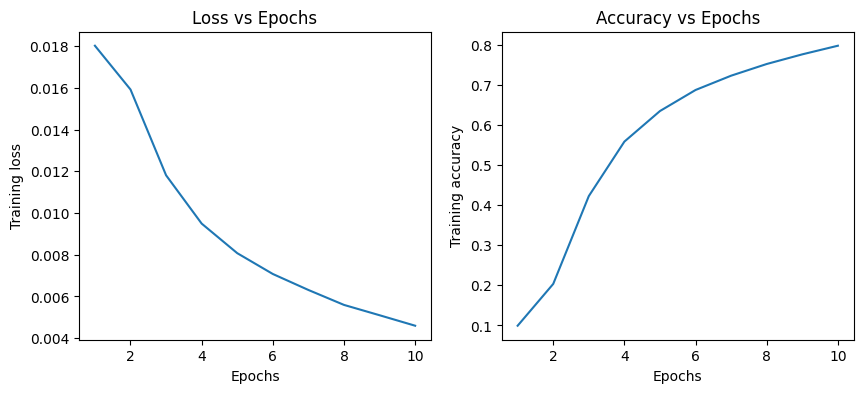

In [36]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [12]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 68 %


In [25]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 66 %


In [38]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 73 %


#Change lr and momentum, different pretrained models, your own images

In [7]:
# Import packages
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import os

In [13]:
# Device configuration (whether to run on GPU or CPU)
#device = 'cpu'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-10-04 02:53:09--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.71, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   209MB/s    in 0.2s    

2023-10-04 02:53:09 (209 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [26]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes

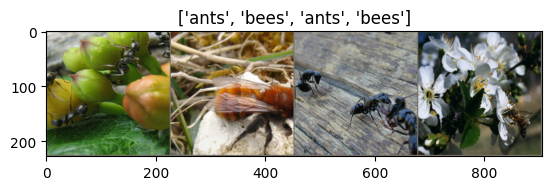

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [29]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
from torchvision import models

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 238MB/s]


In [31]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6883 Acc: 0.5246

Epoch 1/4
----------
Loss: 0.6117 Acc: 0.7008

Epoch 2/4
----------
Loss: 0.5274 Acc: 0.8689

Epoch 3/4
----------
Loss: 0.4826 Acc: 0.8443

Epoch 4/4
----------
Loss: 0.4591 Acc: 0.8525



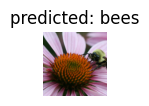

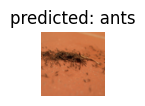

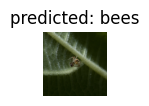

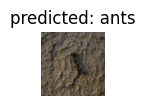

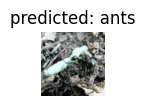

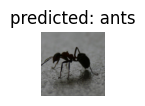

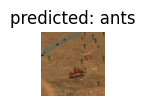

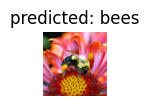

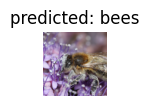

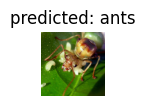

In [32]:
visualize_model(model_ft)

In [33]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [34]:
def predict(image_path, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    image = load_image(image_path).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)

    return predicted.item()

In [35]:
image_path = "/content/ant.jfif"
predicted_class = predict(image_path, model_ft)
print(f"Predicted Class: {class_names[predicted_class]}")


Predicted Class: ants
